In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import json
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
from PIL import Image

In [21]:
# CONSTANTS
BATCH_SIZE = 64

## EDA

In [22]:
with open("./data/label_num_to_disease_map.json") as label_mapping_file:
    label_map = json.load(label_mapping_file)

In [23]:
df_train_img_names = pd.read_csv("./data/train.csv")
# Add a column with disease name
df_train_img_names["disease"] = df_train_img_names.apply(
    lambda row: label_map[str(row["label"])], axis=1
    )
df_train_img_names.head()

,image_id,label,disease
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


Check the disease distribution within the training samples. Distribution doesn't seem balanced with CMD outnumbering other disease types by a wide margin

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: disease, dtype: int64


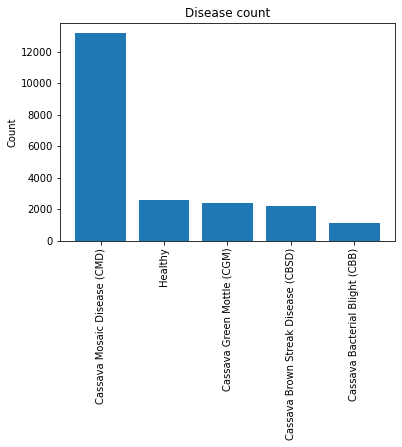

In [24]:
# Disease distribution
disease_counts = df_train_img_names.disease.value_counts()
print(disease_counts)
plt.bar(disease_counts.index, disease_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Disease count")
plt.show()


In [25]:

# split the training dataframe into kfolds for cross validation. We do this before any processing is done
# on the data. We use stratified kfold if the target distribution is unbalanced
def strat_kfold_dataframe(df, target_col_name, num_folds=5):
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # randomize of shuffle the rows of dataframe before splitting is done
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    # get the target data
    y = df[target_col_name].values
    skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X=df, y=y)):
        df.loc[val_index, "kfold"] = fold    
    return df     

df_train_img_names = strat_kfold_dataframe(df_train_img_names, target_col_name="label")
df_train_img_names.head()

,image_id,label,disease,kfold
0,2615227158.jpg,4,Healthy,2
1,1277648239.jpg,3,Cassava Mosaic Disease (CMD),1
2,2305895487.jpg,3,Cassava Mosaic Disease (CMD),2
3,336299725.jpg,2,Cassava Green Mottle (CGM),1
4,1951270318.jpg,2,Cassava Green Mottle (CGM),0


In [26]:
import tqdm

# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html
# https://www.thoughtco.com/sum-of-squares-formula-shortcut-3126266
def get_imgs_mean_stddev(dl_img, axis=None):    
    """Get the mean and standard deviation for images in a dataset / mini-batch.
    img batch is of shape BS * C * H * W 
    where BS = batch_size or no of training samples 
    C = 3 ( RGB channels ), H = height of image matrix, W = width of image matrix
    Args:
        dl_imgs ([DataLoader]): image data loader
        axis ([tuple of ints], optional): Axis along which mean and std dev is to be calculated.
        Defaults to None.
    Returns:
        [tuple]: tuple of tensors with mean and std.dev. of the imgs
    """
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    # sum of pixel values along RGB channels
    psum = torch.Tensor([0.0, 0.0, 0.0])
    # sum of squares of pixel values along RGB channels
    psum_sq = torch.Tensor([0.0, 0.0, 0.0])        
    num_img = 0    
    img_h, img_w = 0, 0    
    count = 0
    for img, label in tqdm.tqdm(dl_img): 
        if count == 0:            
            img_h = img.shape[2]       
            img_w = img.shape[3]
        num_img += img.shape[0]            
        psum += img.sum(axis=[0, 2, 3])        
        img_sq = img.square()
        psum_sq += img_sq.sum(axis=[0, 2, 3])
        count += 1
    # pixel count of single img (index 1 is the height and index 2 is width of img)
    img_pixel_count = img_h * img_w      
    total_pixel_count = num_img * img_pixel_count   
    # mean of pixel values across the dataset        
    total_mean = psum / total_pixel_count    
    # variance of pixel values across the dataset
    total_var = (psum_sq / total_pixel_count) - (total_mean.square())    
    total_std = torch.sqrt(total_var)
    return total_mean, total_std

# Define a custom pytorch Dataset for training

In [27]:
# A dataset contains the logic to fetch, load and if required transform data to bring it to a format
# that can be used by dataloaders for training
class CassavaImageDataset(Dataset):
    def __init__(self, df, img_name_col, target_col, img_root_folder, transform=None, target_transform=None):
        self.df = df
        self.img_name_col = img_name_col
        self.target_col = target_col
        self.img_root_folder = img_root_folder
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_path = self.img_root_folder + "/" + self.df.loc[index, self.img_name_col]
        img = Image.open(img_path)
        img_label = self.df.loc[index, self.target_col]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            img_label = self.target_transform(img_label)
        return img, img_label

    def __len__(self):
        return len(self.df)

In [28]:
train_transform = transforms.Compose([
        transforms.Resize((192,256)),
        transforms.ToTensor()
])

In [29]:
def get_fold_dls(fold, df_imgs):
    df_train = df_imgs[df_imgs["kfold"] != fold].reset_index(drop=True)
    df_val = df_imgs[df_imgs["kfold"] == fold].reset_index(drop=True)    
    ds_train = CassavaImageDataset(
        df_train, 
        img_name_col="image_id",
        target_col="label",
        img_root_folder="./data/train_images", 
        transform=train_transform,
        target_transform=torch.as_tensor
        )
    ds_val = CassavaImageDataset(
        df_val, 
        img_name_col="image_id",
        target_col="label",
        img_root_folder="./data/train_images", 
        transform=train_transform,
        target_transform=torch.as_tensor
        )        
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)    
    dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True)
    return dl_train, dl_val, ds_train, ds_val

In [30]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, df_train_img_names)

In [31]:
# counter = 0
# for imgs, lbls in dl_val:
#     if counter > 0:
#         break
#     img_mean = torch.mean(imgs, axis=(0, 2, 3))
#     img_std = torch.std(imgs, axis=(0, 2, 3))
#     counter += 1
# print(img_mean, img_std)    

In [37]:
ds_all = CassavaImageDataset(
        df_train_img_names, 
        img_name_col="image_id",
        target_col="label",
        img_root_folder="./data/train_images", 
        transform=train_transform,
        target_transform=torch.as_tensor
        )
dl_all = DataLoader(ds_all, batch_size=BATCH_SIZE, shuffle=True)            
img_mean, img_std = get_imgs_mean_stddev(dl_all)
print(f"img mean calculated on entire training dataset = {img_mean}")
print(f"img std calculated on entire training dataset = {img_std}")

100%|██████████| 335/335 [07:18<00:00,  1.31s/it]

img mean calculated on entire training dataset = tensor([0.4303, 0.4967, 0.3135])
img std calculated on entire training dataset = tensor([0.2203, 0.2232, 0.2114])


img mean calculated on entire training dataset = tensor([0.4303, 0.4967, 0.3135])<br>
img std calculated on entire training dataset = tensor([0.2203, 0.2232, 0.2114])

In [11]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(9, 6))
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display
            img = img.transpose(1, 2, 0)
            ax.imshow(Image.fromarray(np.uint8(img)).convert('RGB'))        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

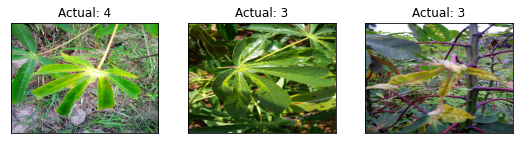

In [17]:
show_batch(ds_train, 3, 1, 3)

In [13]:
from typing import Optional
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, fold, img_root_path, df, img_name_col, target_col, batch_size=64,  
                 input_img_dims=(3,64,64),num_target_classes=4, transforms=None):        
        self.fold = fold
        self.img_root_path = img_root_path  
        self.df = df
        self.img_name_col = img_name_col
        self.target_col = target_col
        self.input_imgs_dims = input_img_dims        
        self.num_target_classes = num_target_classes
        if transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(img_mean, img_std)
            ])
        else:
            self.transforms = transforms    

    def prepare_data(self) -> None:
        return super().prepare_data()       

    def setup(self, stage: Optional[str] = None) -> None:
        return super().setup(stage=stage)                     

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return super().train_dataloader()     

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return super().val_dataloader()    

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return super().test_dataloader()